In [1]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image
import os
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
def lr_schedule(epoch):
    initial_lr = 0.001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 20.0  # Number of epochs after which learning rate should drop
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #horizontal_flip=True,
    #vertical_flip=True,
    rescale=1./255.0)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [6]:
main_path = os.getcwd() + '/covid_data'

train_dataset = train_datagen.flow_from_directory(
    directory= main_path + '/train/',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    seed=None)

val_dataset = val_datagen.flow_from_directory(
    directory = main_path + '/validation',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=128,
    class_mode="categorical",
    shuffle=False,
    seed=None)

test_dataset = test_datagen.flow_from_directory(
    directory = main_path + '/test',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=128,
    class_mode="categorical",
    shuffle=False,
    seed=None)

Found 14811 images belonging to 4 classes.
Found 2119 images belonging to 4 classes.
Found 4235 images belonging to 4 classes.


In [7]:
for image_batch, labels_batch in train_dataset:
  print('Image Shape: {}'.format(image_batch.shape))
  print('Label Shape: {}'.format(labels_batch.shape))
  break

Image Shape: (32, 224, 224, 3)
Label Shape: (32, 4)


In [8]:
# Compute class weights based on the generator's class frequencies
class_labels = list(train_dataset.class_indices.values())
class_weights = compute_class_weight('balanced', class_labels, train_dataset.classes)
class_weights = np.round(class_weights,2)
# Map class indices to class weights
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.46, 1: 0.88, 2: 0.52, 3: 3.93}


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0, 1, 2, 3], y=[0 0 0 ... 3 3 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [9]:
# Load pre-trained ResNet50 model with pre-trained weights and without top layers
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
base_model = ResNet50(weights='imagenet', include_top=False)

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['categorical_accuracy'])

In [10]:
history = model.fit(train_dataset, validation_data=val_dataset,epochs=75,callbacks=[LearningRateScheduler(lr_schedule),early_stopping],class_weight = class_weight_dict)

Epoch 1/75
463/463 [==============================] - 105s 219ms/step - loss: 1.3666 - categorical_accuracy: 0.2880 - val_loss: 1.3632 - val_categorical_accuracy: 0.1803
Epoch 2/75
463/463 [==============================] - 102s 220ms/step - loss: 1.2860 - categorical_accuracy: 0.3856 - val_loss: 1.2177 - val_categorical_accuracy: 0.5521
Epoch 3/75
463/463 [==============================] - 104s 224ms/step - loss: 1.2359 - categorical_accuracy: 0.4424 - val_loss: 1.2602 - val_categorical_accuracy: 0.3034
Epoch 4/75
463/463 [==============================] - 105s 226ms/step - loss: 1.2003 - categorical_accuracy: 0.4643 - val_loss: 1.3167 - val_categorical_accuracy: 0.2978
Epoch 5/75
463/463 [==============================] - 104s 224ms/step - loss: 1.1727 - categorical_accuracy: 0.4688 - val_loss: 1.0670 - val_categorical_accuracy: 0.6220
Epoch 6/75
463/463 [==============================] - 100s 216ms/step - loss: 1.1391 - categorical_accuracy: 0.5137 - val_loss: 1.1780 - val_categoric

463/463 [==============================] - 96s 206ms/step - loss: 0.8594 - categorical_accuracy: 0.6199 - val_loss: 0.9545 - val_categorical_accuracy: 0.6102


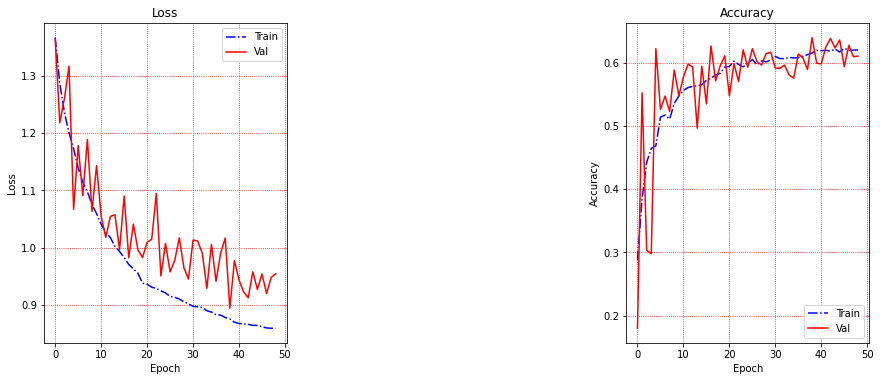

In [13]:
plt.figure(figsize = (20, 20))
plt.subplot(341)
plt.plot(history.history['loss'], color='blue', linestyle = 'dashdot', label='Train')
plt.plot(history.history['val_loss'], color='red', linestyle="solid", label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(visible = True, which = 'both', color= 'r', linestyle = 'dotted')
plt.legend()

plt.subplot(343)
plt.plot(history.history['categorical_accuracy'], color='blue', linestyle = 'dashdot', label='Train')
plt.plot(history.history['val_categorical_accuracy'], color='red', linestyle="solid", label='Val')
# plt.xticks(np.arange(0, 31, step=2))  # Set label locations.
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(visible = True, which = 'both', color= 'r', linestyle = 'dotted')
plt.legend()